## Name: Saikat Bera
## Emai: saikatb@cmi.ac.in
## Roll No.: MDS202228

# Part 2

In [1]:
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import os

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Check for GPU availability
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {DEVICE}')

Using device: cuda


In [4]:
class SentimentDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.length = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __getitem__(self, index):
        text = str(self.data.text[index])
        text = " ".join(text.split())
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        target = self.data.sentiment[index]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(target, dtype=torch.long)
        }

    def __len__(self):
        return self.length

In [5]:
def load_sentiment_data():
    """
    Load and preprocess the sentiment analysis dataset.
    Returns:
        train_df (pandas.DataFrame): The preprocessed training dataset.
        test_df (pandas.DataFrame): The preprocessed test dataset.
    """
    train_df = pd.read_csv('/kaggle/input/sentiment-analysis-dataset/train.csv', encoding='unicode_escape')
    test_df = pd.read_csv('/kaggle/input/sentiment-analysis-dataset/test.csv', encoding='latin1')

    # Define sentiment mapping
    sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}

    # Apply sentiment mapping to the DataFrame
    train_df['sentiment'] = train_df['sentiment'].map(sentiment_mapping)
    test_df['sentiment'] = test_df['sentiment'].map(sentiment_mapping)

    # Check unique targets
    print("Unique targets in train dataset:", pd.unique(train_df['sentiment']))
    print("Unique targets in test dataset:", pd.unique(test_df['sentiment']))

    # Handle NaN values in test dataset
    nan_counts = test_df.isna().sum()
    print("Number of NaN values in each column:\n", nan_counts)
    test_df.dropna(inplace=True)
    nan_counts = test_df.isna().sum()
    print("Number of NaN values in each column:\n", nan_counts)

    return train_df, test_df

def create_data_loaders(train_df, test_df, max_length, batch_size):
    """
    Create PyTorch data loaders for the sentiment analysis task.
    Args:
        train_df (pandas.DataFrame): The preprocessed training dataset.
        test_df (pandas.DataFrame): The preprocessed test dataset.
        max_length (int): The maximum length of the input sequences.
        batch_size (int): The batch size for the data loaders.
    Returns:
        train_loader (torch.utils.data.DataLoader): The training data loader.
        test_loader (torch.utils.data.DataLoader): The test data loader.
    """
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    train_dataset = SentimentDataset(train_df, tokenizer, max_length)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = SentimentDataset(test_df, tokenizer, max_length)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, test_loader

def load_sentiment_model():
    """
    Load the BERT-based sentiment classification model.
    Returns:
        model (transformers.BertForSequenceClassification): The loaded sentiment classification model.
    """
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
    model.to(DEVICE)
    return model

def train_sentiment_model(model, optimizer, train_loader, epoch, checkpoint_path):
    """
    Train the sentiment classification model.
    Args:
        model (transformers.BertForSequenceClassification): The sentiment classification model.
        optimizer (torch.optim.Optimizer): The optimizer for training the model.
        train_loader (torch.utils.data.DataLoader): The training data loader.
        epoch (int): The current epoch of training.
        checkpoint_path (str): The file path to save the model checkpoint.
    Returns:
        train_losses (list): The training losses for the current epoch.
        train_accuracies (list): The training accuracies for the current epoch.
    """
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    train_losses = []
    train_accuracies = []

    for _, data in enumerate(train_loader, 0):
        ids = data['ids'].to(DEVICE)
        mask = data['mask'].to(DEVICE)
        token_type_ids = data['token_type_ids'].to(DEVICE)
        targets = data['targets'].to(DEVICE)

        outputs = model(ids, mask, token_type_ids, labels=targets)
        loss = outputs[0]

        if _ % 5000 == 0:
            print(f'Epoch: {epoch}, Loss: {loss.item()}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        preds = torch.argmax(outputs.logits, dim=1)
        correct_predictions += torch.sum(preds == targets)
        total_predictions += targets.size(0)

    average_loss = running_loss / len(train_loader)
    train_losses.append(average_loss)

    train_accuracy = correct_predictions.double() / total_predictions
    train_accuracies.append(train_accuracy.item())

    save_checkpoint(epoch, model, optimizer, checkpoint_path)
    return train_losses, train_accuracies

def save_checkpoint(epoch, model, optimizer, filename):
    """
    Save the model and optimizer state as a checkpoint.
    Args:
        epoch (int): The current epoch of training.
        model (transformers.BertForSequenceClassification): The sentiment classification model.
        optimizer (torch.optim.Optimizer): The optimizer for training the model.
        filename (str): The file path to save the checkpoint.
    """
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved at epoch {epoch+1}")

def evaluate_sentiment_model(model, test_loader):
    """
    Evaluate the sentiment classification model on the test dataset.
    Args:
        model (transformers.BertForSequenceClassification): The sentiment classification model.
        test_loader (torch.utils.data.DataLoader): The test data loader.
    Returns:
        targets (list): The true targets (labels) of the test dataset.
        outputs (list): The predicted outputs of the model on the test dataset.
        val_losses (list): The validation losses for the test dataset.
        val_accuracies (list): The validation accuracies for the test dataset.
    """
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    final_targets, final_outputs = [], []
    val_losses, val_accuracies = [], []

    with torch.no_grad():
        for _, data in enumerate(test_loader, 0):
            ids = data['ids'].to(DEVICE)
            mask = data['mask'].to(DEVICE)
            token_type_ids = data['token_type_ids'].to(DEVICE)
            targets = data['targets'].to(DEVICE)
            outputs = model(ids, mask, token_type_ids, labels=targets)

            logits = outputs.logits
            loss = outputs.loss
            running_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct_predictions += torch.sum(preds == targets)
            total_predictions += targets.size(0)

            final_targets.extend(targets.cpu().detach().numpy().tolist())
            final_outputs.extend(preds.cpu().detach().numpy().tolist())

    average_loss = running_loss / len(test_loader)
    accuracy = correct_predictions.double() / total_predictions

    val_losses.append(average_loss)
    val_accuracies.append(accuracy.item())
    return final_targets, final_outputs, val_losses, val_accuracies

Unique targets in train dataset: [1 0 2]
Unique targets in test dataset: [ 1.  2.  0. nan]
Number of NaN values in each column:
 textID              1281
text                1281
sentiment           1281
Time of Tweet       1281
Age of User         1281
Country             1281
Population -2020    1281
Land Area (Km²)     1281
Density (P/Km²)     1281
dtype: int64
Number of NaN values in each column:
 textID              0
text                0
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0, Loss: 1.0349843502044678


 33%|███▎      | 1/3 [11:04<22:09, 664.72s/it]

Checkpoint saved at epoch 1
Epoch: 1, Loss: 0.3726155161857605


 67%|██████▋   | 2/3 [22:10<11:05, 665.63s/it]

Checkpoint saved at epoch 2
Epoch: 2, Loss: 0.3518732786178589


100%|██████████| 3/3 [33:17<00:00, 665.93s/it]

Checkpoint saved at epoch 3


              precision    recall  f1-score   support

    negative       0.76      0.85      0.80      1001
     neutral       0.77      0.74      0.76      1430
    positive       0.87      0.81      0.84      1103

    accuracy                           0.79      3534
   macro avg       0.80      0.80      0.80      3534
weighted avg       0.80      0.79      0.79      3534



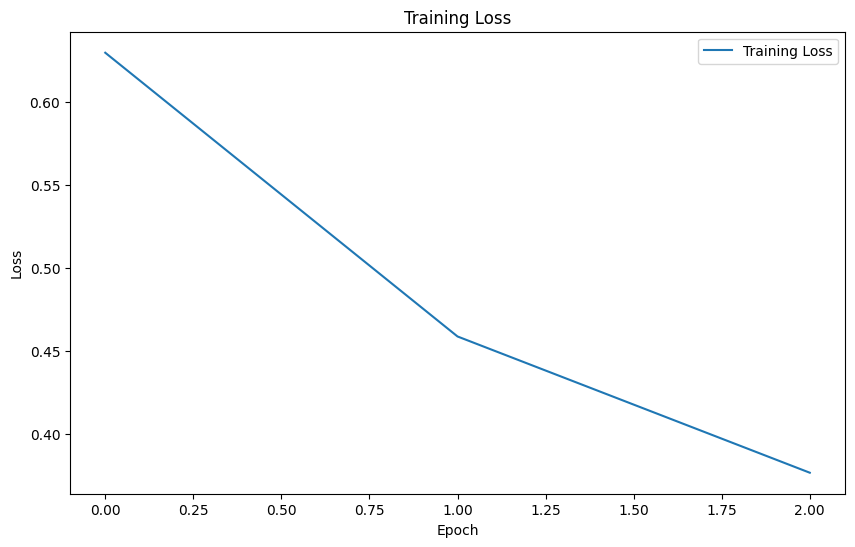

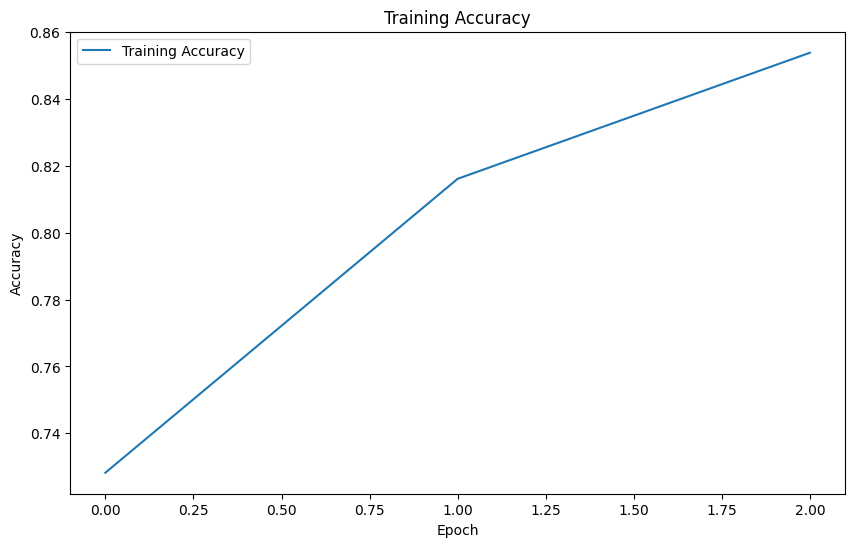

In [6]:
def main():
    """
    The main function that orchestrates the sentiment analysis task.
    """
    # Load sentiment data
    train_df, test_df = load_sentiment_data()

    # Create data loaders
    MAX_LENGTH = 256
    TRAIN_BATCH_SIZE = 32
    VALID_BATCH_SIZE = 32
    train_loader, test_loader = create_data_loaders(train_df, test_df, MAX_LENGTH, TRAIN_BATCH_SIZE)

    # Load sentiment model
    model = load_sentiment_model()

    # Optimizer
    optimizer = AdamW(model.parameters(), lr=1e-5)

    # Checkpoint path
    CHECKPOINT_PATH = "model_checkpoint.pt"

    # Run training
    train_losses, train_accuracies = [], []
    for epoch in tqdm(range(0, 3)):
        train_loss, train_accuracy = train_sentiment_model(model, optimizer, train_loader, epoch, CHECKPOINT_PATH)
        train_losses.extend(train_loss)
        train_accuracies.extend(train_accuracy)

    # Evaluate sentiment model
    targets, outputs, val_losses, val_accuracies = evaluate_sentiment_model(model, test_loader)
    print(classification_report(targets, outputs, target_names=['negative', 'neutral', 'positive']))

    # Plot training loss, training accuracy, and validation accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.savefig('training_loss.png')

    plt.figure(figsize=(10, 6))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()
    plt.savefig('training_accuracy.png')
    

if __name__ == "__main__":
    main()